2023.04.10 박진윤 선임연구원, 태안군 인공지능유합산업진흥원

## Visualize Florence 3D public dataset

In [1]:
dataset_name = 'FLO'

In [2]:
ori_dir = './dataset/Florence3D/'
prcs_dir = f'./dataset/preprocess/{dataset_name}/'

## Library import

In [3]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
import os
import natsort
import imageio
import cv2
import glob
import io

# %matplotlib notebook

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ohywgfor because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
def createFolder(directory):
    try:
        if os.path.exists(directory):
            print('Already Exists')
        if not os.path.exists(directory):
            os.makedirs(directory)
            print('Sucess creating directory. -> ' + directory)
    except OSError:
        print ('Error: Creating directory.' +  directory)

## Assert joint index
- 데이터 인텍스별로 해당되는 관절 인덱트
- motion class 이름 및 인덱스

In [5]:
bones_3d = [[0, 1, 2],
            [1, 2, 2],
            [1, 3, 1],
            [3, 4, 1],
            [4, 5, 1],
            [1, 6, 0],
            [6, 7, 0],
            [7, 8, 0],
            [2, 9, 1],
            [9, 10, 1],
            [10, 11, 1],
            [2, 12, 0],
            [12, 13, 0],
            [13, 14, 0]] #0 == red/right, 1 == blue/left, 2 == black/mid

In [6]:
activity = [[0, 'wave'],
           [1,'drink'],
           [2, 'answer_phone'],
           [3, 'clap'],
           [4, 'tight_lace'],
           [5, 'sit_down'],
           [6, 'stand_up'],
           [7, 'read_watch'],
           [8, 'bow']]

## Check data format

In [7]:
#파일이름 적기
file_name = ori_dir + 'Florence_dataset_WorldCoordinates.txt'

데이터 구조 확인

In [8]:
# loading the original FLO data
data = np.loadtxt(file_name)
len(data[0]), data[0]

(48,
 array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, -2.22737122e+02,
         5.40995422e+02,  2.83240991e+03, -2.33136169e+02,  2.88886017e+02,
         2.80875928e+03, -2.26604401e+02,  8.51141815e+01,  2.79697852e+03,
        -3.88270691e+02,  2.82664948e+02,  2.83035205e+03, -4.83233032e+02,
         3.28398705e+01,  2.86478760e+03, -6.06122986e+02, -2.07372986e+02,
         2.72130591e+03, -7.80016479e+01,  2.95107086e+02,  2.78716675e+03,
         2.40116882e+01,  5.93040581e+01,  2.84850757e+03,  1.86018677e+02,
        -1.81273209e+02,  2.70788794e+03, -3.15452179e+02, -1.22482491e+02,
         2.79847314e+03, -3.48947784e+02, -5.66769897e+02,  2.79553076e+03,
        -3.76748260e+02, -9.77205017e+02,  2.84771655e+03, -1.24693100e+02,
        -1.14832840e+02,  2.77192212e+03, -7.86131210e+01, -5.42027649e+02,
         2.77143604e+03, -1.81917305e+01, -9.30296204e+02,  2.82743799e+03]))

시각화를 통해 기존의 데이터 확인

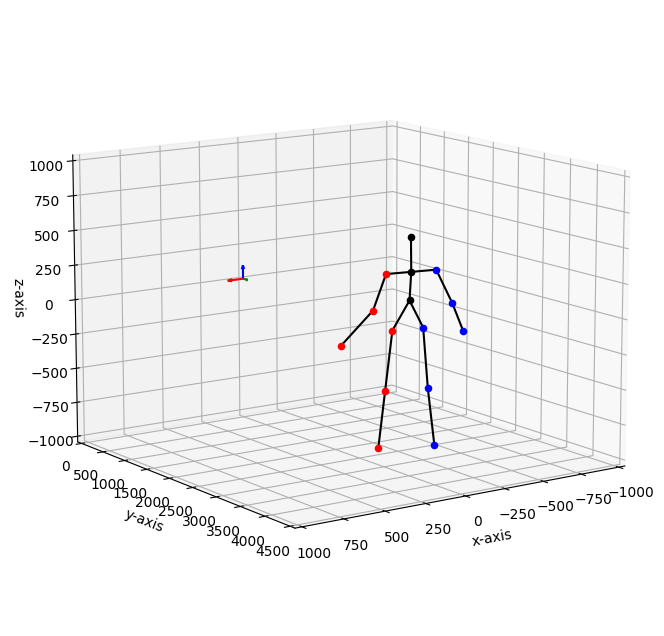

In [18]:
plt.ioff()
fig = plt.figure(figsize=(8,8))

ax_3d = []
lines_3d = []
radius = 1.5
elev= 12
azim = 55


ax = fig.add_subplot(projection='3d')
ax.view_init(elev,azim) #(elev = 위아래, azim = 좌우)
ax.set_xlim([-1000,1000])
ax.set_ylim([0,4500])
ax.set_zlim([-1000,1000])


ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax_3d.append(ax)


for bone in bones_3d:
    start = bone[0]+1
    end = bone[1]+1

    col = 'black' if bone[2] == 0 else 'black' #red = right, blue = left

    x = [(data[0][start*3]), (data[0][end*3])]
    y = [(data[0][start*3+2]), (data[0][end*3+2])]
    z = [(data[0][start*3+1]), (data[0][end*3+1])]

    ax.plot(x, y, z, c = col)

for i in range(15):
    if i in [3,4,5,9,10,11]: col = 'blue'
    elif i in [0,1,2,15]: col = 'black'
    else: col = 'red'
    i=i+1
    x = data[0][i*3]
    y = data[0][i*3+2]
    z = data[0][i*3+1]

    ax.scatter3D(x, y, z, c = col)    

ax.quiver(0,0,0,100,0,0, color='r') #x-axis , label = 'x'
ax.quiver(0,0,0,0,100,0, color='g') #y-axis , label = 'y'
ax.quiver(0,0,0,0,0,100, color='b') #z-axis , label = 'z'

plt.show()

Florence dataset form is in x, z, y order

## Rearrange data format
- 제공되는 데이터셋의 구조를 재설정
- motion class에 따라 폴더별로 파일 저장
- FLO 데이터셋은 모든 데이터가 하나의 파일에 포함되어 있어 일일이 분리해주는 작업이 들어가야함. 

In [19]:
for i in activity:
    createFolder(prcs_dir + '{}'.format(i[1]))

Sucess creating directory. -> ./dataset/preprocess/FLO/wave
Sucess creating directory. -> ./dataset/preprocess/FLO/drink
Sucess creating directory. -> ./dataset/preprocess/FLO/answer_phone
Sucess creating directory. -> ./dataset/preprocess/FLO/clap
Sucess creating directory. -> ./dataset/preprocess/FLO/tight_lace
Sucess creating directory. -> ./dataset/preprocess/FLO/sit_down
Sucess creating directory. -> ./dataset/preprocess/FLO/stand_up
Sucess creating directory. -> ./dataset/preprocess/FLO/read_watch
Sucess creating directory. -> ./dataset/preprocess/FLO/bow


In [20]:
#loading the data into the form of (N, 15, 3)
ins = []
info = [] ## list of information about each frame (subject, instance, class)
for i in range(len(data)):
    #allocating the [sample number, subject, activity] into info
    info.append([(data[i][0]), data[i][1], data[i][2]])
    joint = []
    for j in range(3, 48, 3):
        x = float(data[i][j])
        y = float(data[i][j+1])
        z = float(data[i][j+2])
        joint.append([x,y,z])
    ins.append(joint)
    
ins = np.asarray(ins)
# [sample number, subject, activity]
info = np.asarray(info)

ins.shape, info.shape

((4016, 15, 3), (4016, 3))

In [21]:
# info를 action별로 묶어두기
data_info = [[] for i in range(9)]
for i in range(1, 10):
    for j in range(len(info)):
        if info[j][2] == i:
            data_info[i-1].append(info[j].tolist())
            
data_info = np.array(data_info)
data_info.shape

<ipython-input-21-6b2c956e5b43>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_info = np.array(data_info)


(9,)

In [22]:
# [activity sample number, subject, activity]
# data_info -> repeated info due to the frames in one incident(sample)
# unique_info -> deleted the repeated sample info

unique_info = []
for action in data_info:
    for frame in action:
        if frame not in unique_info:
            unique_info.append(frame)
            
unique_info = np.array(unique_info)
unique_info.shape

(215, 3)

In [23]:
a = 1
for i in range(len(unique_info)):
    if unique_info[i][2] == a:
        print(unique_info[i])
    else:
        print('\n')
        a+=1
    

[1. 1. 1.]
[2. 1. 1.]
[3. 1. 1.]
[30.  2.  1.]
[31.  2.  1.]
[48.  3.  1.]
[49.  3.  1.]
[50.  3.  1.]
[69.  4.  1.]
[70.  4.  1.]
[71.  4.  1.]
[88.  5.  1.]
[89.  5.  1.]
[108.   6.   1.]
[109.   6.   1.]
[110.   6.   1.]
[130.   7.   1.]
[131.   7.   1.]
[149.   8.   1.]
[150.   8.   1.]
[173.   9.   1.]
[174.   9.   1.]
[193.  10.   1.]
[194.  10.   1.]


[5. 1. 2.]
[6. 1. 2.]
[32.  2.  2.]
[33.  2.  2.]
[51.  3.  2.]
[52.  3.  2.]
[72.  4.  2.]
[73.  4.  2.]
[90.  5.  2.]
[91.  5.  2.]
[111.   6.   2.]
[112.   6.   2.]
[132.   7.   2.]
[133.   7.   2.]
[151.   8.   2.]
[152.   8.   2.]
[175.   9.   2.]
[176.   9.   2.]
[195.  10.   2.]
[196.  10.   2.]


[8. 1. 3.]
[9. 1. 3.]
[34.  2.  3.]
[35.  2.  3.]
[53.  3.  3.]
[54.  3.  3.]
[74.  4.  3.]
[75.  4.  3.]
[92.  5.  3.]
[93.  5.  3.]
[94.  5.  3.]
[113.   6.   3.]
[114.   6.   3.]
[134.   7.   3.]
[135.   7.   3.]
[153.   8.   3.]
[154.   8.   3.]
[177.   9.   3.]
[178.   9.   3.]
[197.  10.   3.]
[198.  10.   3.]


[11.  1.  4.

In [24]:
data_value = [[] for i in range(3)]
for info in unique_info:
    subject = int(info[1])
    action = int(info[2])
    sample = int(info[0])
    
    # name of the new format data
    txt_file = prcs_dir + '{}/a{}_s{}_e{}.txt'.format(activity[action-1][1], action, subject, sample)
    print(txt_file, '\n')
    
    with open(txt_file, 'w') as f:
        for i in range(len(data)):
            if (data[i][0] == sample)&(data[i][1] == subject)&(data[i][2] == action):
                for j in range(3, 48, 3):
                    x = str(data[i][j])
                    z = str(data[i][j+1])
                    y = str(data[i][j+2])
                    data_value[0].append(float(x))
                    data_value[1].append(float(y))
                    data_value[2].append(float(z))
                    f.write(x + '\t' + y + '\t' + z + '\t')
            else:
                continue
            f.write('\n')
        f.close()

./dataset/preprocess/FLO/wave/a1_s1_e1.txt 

./dataset/preprocess/FLO/wave/a1_s1_e2.txt 

./dataset/preprocess/FLO/wave/a1_s1_e3.txt 

./dataset/preprocess/FLO/wave/a1_s2_e30.txt 

./dataset/preprocess/FLO/wave/a1_s2_e31.txt 

./dataset/preprocess/FLO/wave/a1_s3_e48.txt 

./dataset/preprocess/FLO/wave/a1_s3_e49.txt 

./dataset/preprocess/FLO/wave/a1_s3_e50.txt 

./dataset/preprocess/FLO/wave/a1_s4_e69.txt 

./dataset/preprocess/FLO/wave/a1_s4_e70.txt 

./dataset/preprocess/FLO/wave/a1_s4_e71.txt 

./dataset/preprocess/FLO/wave/a1_s5_e88.txt 

./dataset/preprocess/FLO/wave/a1_s5_e89.txt 

./dataset/preprocess/FLO/wave/a1_s6_e108.txt 

./dataset/preprocess/FLO/wave/a1_s6_e109.txt 

./dataset/preprocess/FLO/wave/a1_s6_e110.txt 

./dataset/preprocess/FLO/wave/a1_s7_e130.txt 

./dataset/preprocess/FLO/wave/a1_s7_e131.txt 

./dataset/preprocess/FLO/wave/a1_s8_e149.txt 

./dataset/preprocess/FLO/wave/a1_s8_e150.txt 

./dataset/preprocess/FLO/wave/a1_s9_e173.txt 

./dataset/preprocess/FLO/wave

./dataset/preprocess/FLO/read_watch/a8_s8_e168.txt 

./dataset/preprocess/FLO/read_watch/a8_s9_e189.txt 

./dataset/preprocess/FLO/read_watch/a8_s9_e190.txt 

./dataset/preprocess/FLO/read_watch/a8_s10_e210.txt 

./dataset/preprocess/FLO/read_watch/a8_s10_e211.txt 

./dataset/preprocess/FLO/bow/a9_s1_e26.txt 

./dataset/preprocess/FLO/bow/a9_s1_e27.txt 

./dataset/preprocess/FLO/bow/a9_s1_e28.txt 

./dataset/preprocess/FLO/bow/a9_s1_e29.txt 

./dataset/preprocess/FLO/bow/a9_s2_e46.txt 

./dataset/preprocess/FLO/bow/a9_s2_e47.txt 

./dataset/preprocess/FLO/bow/a9_s3_e66.txt 

./dataset/preprocess/FLO/bow/a9_s3_e67.txt 

./dataset/preprocess/FLO/bow/a9_s3_e68.txt 

./dataset/preprocess/FLO/bow/a9_s4_e86.txt 

./dataset/preprocess/FLO/bow/a9_s4_e87.txt 

./dataset/preprocess/FLO/bow/a9_s5_e105.txt 

./dataset/preprocess/FLO/bow/a9_s5_e106.txt 

./dataset/preprocess/FLO/bow/a9_s5_e107.txt 

./dataset/preprocess/FLO/bow/a9_s6_e126.txt 

./dataset/preprocess/FLO/bow/a9_s6_e127.txt 

./datase

In [32]:
# checking the written files
with open(txt_file, 'r') as f:
    test = [x.strip().split('\t') for x in f]
    
test = np.array(test)
test.shape, test[0]

((27, 45),
 array(['-222.73712158203125', '2832.409912109375', '540.9954223632812',
        '-233.13616943359375', '2808.75927734375', '288.8860168457031',
        '-226.60440063476562', '2796.978515625', '85.11418151855469',
        '-388.27069091796875', '2830.35205078125', '282.6649475097656',
        '-483.2330322265625', '2864.78759765625', '32.83987045288086',
        '-606.1229858398438', '2721.305908203125', '-207.37298583984375',
        '-78.00164794921875', '2787.166748046875', '295.1070861816406',
        '24.011688232421875', '2848.507568359375', '59.30405807495117',
        '186.0186767578125', '2707.887939453125', '-181.27320861816406',
        '-315.4521789550781', '2798.47314453125', '-122.48249053955078',
        '-348.9477844238281', '2795.53076171875', '-566.7698974609375',
        '-376.7482604980469', '2847.716552734375', '-977.2050170898438',
        '-124.69309997558594', '2771.922119140625', '-114.83283996582031',
        '-78.61312103271484', '2771.43603515625

# visualization

In [34]:
txt_file = prcs_dir + '{}/a{}_s{}_e{}.txt'.format(activity[0][1], activity[0][0]+1, 1, 1)
print(txt_file)

with open(txt_file, 'r') as f:
    test = [x.strip().split('\t') for x in f]
    
test = np.array(test)
test = test.astype('float64')
np.shape(test), test[0]

./dataset/preprocess/FLO/wave/a1_s1_e1.txt


((27, 45),
 array([-222.73712158, 2832.40991211,  540.99542236, -233.13616943,
        2808.75927734,  288.88601685, -226.60440063, 2796.97851562,
          85.11418152, -388.27069092, 2830.35205078,  282.66494751,
        -483.23303223, 2864.78759766,   32.83987045, -606.12298584,
        2721.3059082 , -207.37298584,  -78.00164795, 2787.16674805,
         295.10708618,   24.01168823, 2848.50756836,   59.30405807,
         186.01867676, 2707.88793945, -181.27320862, -315.45217896,
        2798.47314453, -122.48249054, -348.94778442, 2795.53076172,
        -566.76989746, -376.7482605 , 2847.71655273, -977.20501709,
        -124.69309998, 2771.92211914, -114.83283997,  -78.61312103,
        2771.43603516, -542.02764893,  -18.1917305 , 2827.43798828,
        -930.29620361]))

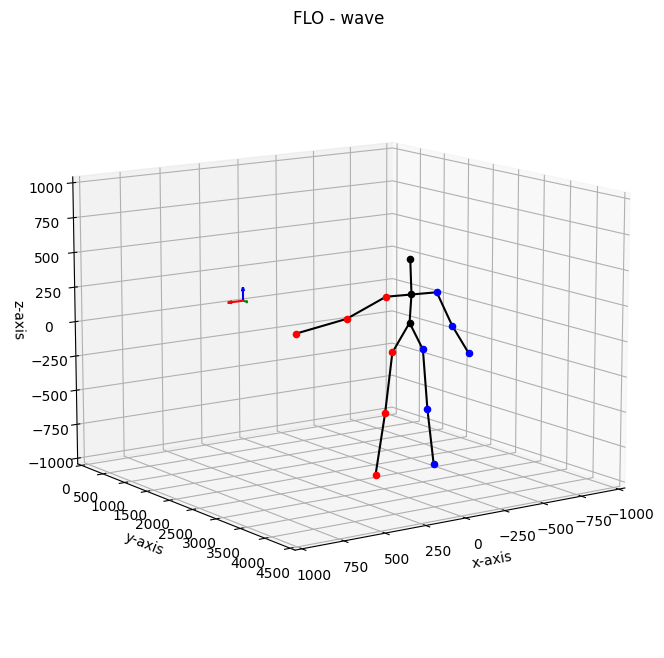

In [35]:
##viewing just one frame each
frame_idx = 10

plt.ioff()
fig = plt.figure(figsize=(8,8))

ax_3d = []
lines_3d = []
radius = 1.5
elev= 12
azim = 55


ax = fig.add_subplot(projection='3d')
ax.view_init(elev,azim) #(elev = 위아래, azim = 좌우)
ax.set_xlim([-1000,1000])
ax.set_ylim([0,4500])
ax.set_zlim([-1000,1000])


ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax_3d.append(ax)


for bone in bones_3d:
    start = bone[0]
    end = bone[1]

    col = 'black' if bone[2] == 0 else 'black' #red = right, blue = left

    x = [(test[frame_idx][start*3]), (test[frame_idx][end*3])]
    y = [(test[frame_idx][start*3+1]), (test[frame_idx][end*3+1])]
    z = [(test[frame_idx][start*3+2]), (test[frame_idx][end*3+2])]

    ax.plot(x, y, z, c = col)

for i in range(len(ins[frame_idx])):
    if i in [3,4,5,9,10,11]: col = 'blue'
    elif i in [0,1,2]: col = 'black'
    else: col = 'red'
    x = test[frame_idx][i*3]
    y = test[frame_idx][i*3+1]
    z = test[frame_idx][i*3+2]

    ax.scatter3D(x, y, z, c = col)    

ax.quiver(0,0,0,100,0,0, color='r') #x-axis , label = 'x'
ax.quiver(0,0,0,0,100,0, color='g') #y-axis , label = 'y'
ax.quiver(0,0,0,0,0,100, color='b') #z-axis , label = 'z'

plt.title('{} - {}'.format(dataset_name, activity[0][1]))
plt.show()